In [553]:
import pandas as pd
import seaborn as sns
import numpy as np
import collections
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import warnings
warnings.filterwarnings('ignore')

In [539]:
# functions
def prediction_vs_result(fit_object,original_outcomes,held_out_set):
    prediction = fit_object.predict(held_out_set)
    frame = pd.concat([original_outcomes,prediction], axis=1)
    frame.columns = ['actual','predicted']
    return(frame)

# pseudo r2
def pseudor2(frame): # first column actual, second column predicted
    ss_res = (np.sum(frame.iloc[:,0] - frame.iloc[:,1]))**2
    ss_total = (np.sum(frame.iloc[:,0] - np.mean(frame.iloc[:,0])))**2
    return(1-(ss_res/ss_total))

In [513]:
refugees = pd.read_csv("refugees.csv")
refugees['date_recode'] = pd.to_datetime(refugees['date_recode'])

refugees_wlags = pd.read_csv("refugees_wlags.csv").fillna(0)
refugees_wlags['date_recode'] = pd.to_datetime(refugees_wlags['date_recode'])
Y_wlags = refugees_wlags['Value']
X_wlags = refugees_wlags.iloc[:,4:].fillna(0)

# create a factor variable
refugees['origin_factor'], origin_labels = pd.factorize(refugees['Code_origin'])
refugees['destination_factor'], destination_labels = pd.factorize(refugees['Code_destination'])
refugees_wlags['origin_factor'], origin_labels_lags = pd.factorize(refugees_wlags['Code_origin'])
refugees_wlags['destination_factor'], destination_labels_lags = pd.factorize(refugees_wlags['Code_destination'])



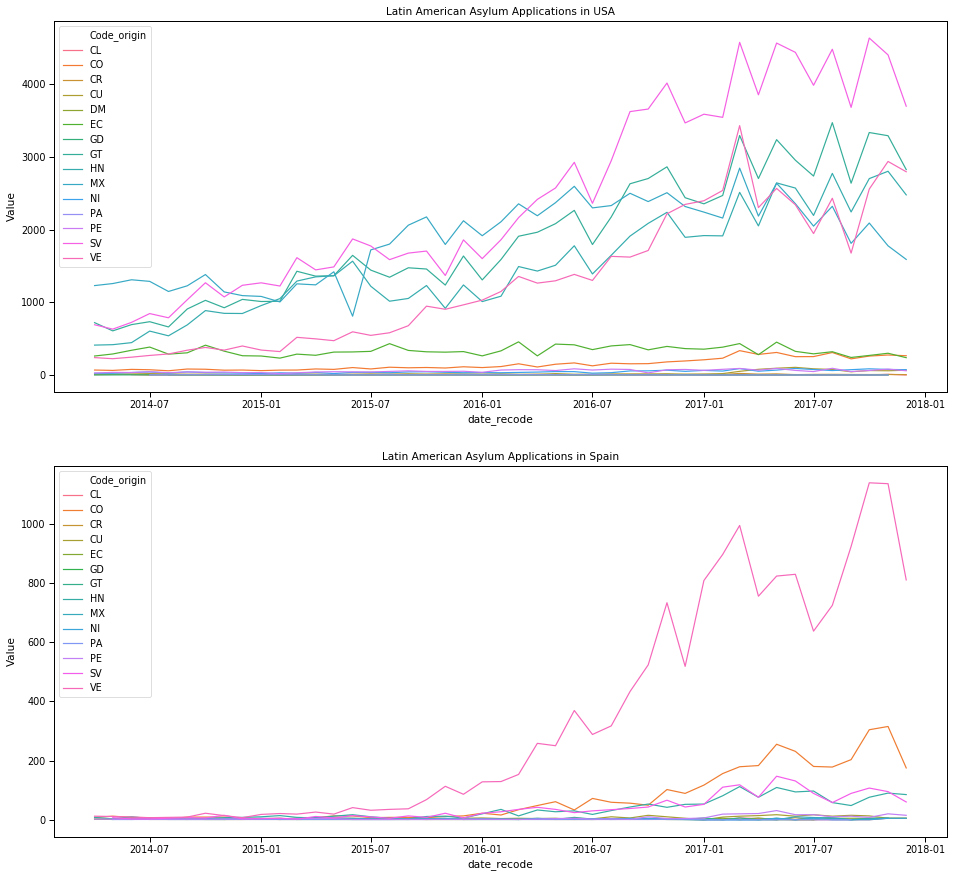

In [453]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,15))
plt.subplots_adjust(wspace=1)

# u.s.a. and spain
sns.set_context("paper",font_scale=1.1)
sns.lineplot(x="date_recode", y="Value", hue="Code_origin", data=refugees[refugees['Code_destination']=="US"], ax = ax1).set_title("Latin American Asylum Applications in USA")
sns.lineplot(x="date_recode", y="Value", hue="Code_origin", data=refugees[refugees['Code_destination']=="ES"], ax = ax2).set_title("Latin American Asylum Applications in Spain")
#### FIRST IDEA: compare latin american countries

plt.show()

In [454]:
# regression setup

refugees_dummies = pd.get_dummies(refugees)
refugees_no_vz = refugees_dummies[refugees_dummies.Code_origin_VE == 0]
refugees_vz = refugees_dummies[refugees_dummies.Code_origin_VE == 1]
vz_Y = refugees_vz['Value']
vz_X = refugees_vz[[col for col in refugees_vz.columns if (col != "Value") & (col != "date_recode")]]

# outcome var
Y = refugees_no_vz['Value']

# convariate matrix
X = refugees_no_vz[[col for col in refugees_no_vz.columns if (col != "Value") & (col != "date_recode")]]
X.head()

X_nodummies = X[[col for col in X.columns if '_origin_' not in col and '_destination_' not in col]]

In [455]:
# A simple poisson model: value against term with interactions
poisson_1 = sm.GLM(Y, X, family=sm.families.Poisson())
poisson_1_fit = poisson_1.fit()
poisson_1_pred = prediction_vs_result(poisson_1_fit, vz_Y, vz_X)
pseudor2(poisson_1_pred)

# lol no

-4.7189071478952304e+33

In [498]:
# OLS with everything
nb_1 = sm.OLS(Y, X)
nb_1_fit = nb_1.fit()
nb_1_pred = prediction_vs_result(nb_1_fit, vz_Y, vz_X)
pseudor2(nb_1_pred)

-4.0044718772764284e+33

In [375]:
# predicting diff

ols_2 = smf.ols('Value_diff ~ inmigrar_EEUU_diff_lag1 + asilo_EEUU_diff_lag1 + asilo_españa_diff_lag1 + inmigrar_españa_diff_lag1 + C(Code_origin) + C(Code_destination)',data=refugees_wlags)
ols_2_fit = ols_2.fit()
ols_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Value_diff   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9474
Date:                Fri, 26 Apr 2019   Prob (F-statistic):              0.514
Time:                        17:47:04   Log-Likelihood:                -3584.6
No. Observations:                 528   AIC:                             7203.
Df Residuals:                     511   BIC:                             7276.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -31.1980     73.276     -0.426      0.670    -175.157     112.761
C(Code_origin)[T.CO]         21.1522     74.985      0.282      0.778    -126.164     168.469
C(Code_origin)[T.CR]          1.6940     78.582      0.022      0.983    -152.690     156.078
C(Code_origin)[T.CU]          9.0781     76.727      0.118      0.906    -141.660     159.816
C(Code_origin)[T.EC]         -0.5913     78.582     -0.008      0.994    -154.974     153.792
C(Code_origin)[T.GT]         53.4523     78.581      0.680      0.497    -100.929     207.833
C(Code_origin)[T.HN]         37.5942     74.987      0.501      0.616    -109.726     184.914
C(Code_origin)[T.MX]         17.7302     78.581      0.226      0.822    -136.650     172.111
C(Code_origin)[T.NI]          1.1811     78.580      0.015      0.988    -153.199     155.561
C(Code_origin)[T.PE]          8.5407     76.726      0.111      0.911    -142.197     159.278
C(Code_origin)[T.SV]         57.1683     75.606      0.756      0.450     -91.369     205.705
C(Code_origin)[T.VE]         60.5929     74.992      0.808      0.419     -86.738     207.924
C(Code_destination)[T.US]    31.1469     24.451      1.274      0.203     -16.891      79.185
inmigrar_EEUU_diff_lag1      -0.8211      2.540     -0.323      0.747      -5.812       4.170
asilo_EEUU_diff_lag1         -0.2077      2.657     -0.078      0.938      -5.428       5.012
asilo_españa_diff_lag1       -3.1494      4.974     -0.633      0.527     -12.921       6.622
inmigrar_españa_diff_lag1    -0.7441      4.754     -0.157      0.876     -10.085       8.596
==============================================================================
Omnibus:                       78.782   Durbin-Watson:                   2.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              881.747
Skew:                          -0.079   Prob(JB):                    3.40e-192
Kurtosis:                       9.329   Cond. No.                         278.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [410]:
# predicting diff without fixed effects

ols_3 = smf.ols('Value_diff ~ np.power(inmigrar_EEUU_diff_lag1,2) + asilo_EEUU_diff_lag1 + asilo_españa_diff_lag1 + inmigrar_españa_diff_lag1',data=refugees_wlags)
ols_3_fit = ols_3.fit()
ols_3_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Value_diff   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.849
Date:                Fri, 26 Apr 2019   Prob (F-statistic):             0.0234
Time:                        17:55:38   Log-Likelihood:                -3586.7
No. Observations:                 528   AIC:                             7183.
Df Residuals:                     523   BIC:                             7205.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               24.2669     10.102      2.402      0.017       4.422      44.112
np.power(inmigrar_EEUU_diff_lag1, 2)    -0.0803      0.056     -1.425      0.155      -0.191       0.030
asilo_EEUU_diff_lag1                    -1.3811      1.279     -1.080      0.281      -3.894       1.132
asilo_españa_diff_lag1                  -2.7268      4.834     -0.564      0.573     -12.223       6.769
inmigrar_españa_diff_lag1               -1.2902      4.614     -0.280      0.780     -10.355       7.775
==============================================================================
Omnibus:                       82.751   Durbin-Watson:                   2.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              834.726
Skew:                           0.266   Prob(JB):                    5.51e-182
Kurtosis:                       9.137   Cond. No.                         197.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

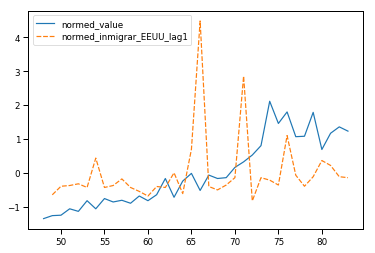

In [377]:
# colombia tracking lagged interest with immigration
colombia = refugees_wlags[refugees_wlags['Name_origin'] == "Colombia"]
colombia_to_us = colombia[colombia['Code_destination'] == "US"]
colombia_to_es = colombia[colombia['Code_destination'] == "ES"]

# let's just look at usa
colombia_to_us['normed_value'] = (colombia_to_us['Value'] - np.mean(colombia_to_us['Value']))/np.std(colombia_to_us['Value'])                                                                                            
colombia_to_us['normed_inmigrar_EEUU_lag1'] = (colombia_to_us['inmigrar_EEUU_lag1'] - np.mean(colombia_to_us['inmigrar_EEUU_lag1']))/np.std(colombia_to_us['inmigrar_EEUU_lag1'])

sns.lineplot(data=colombia_to_us[['normed_value','normed_inmigrar_EEUU_lag1']])


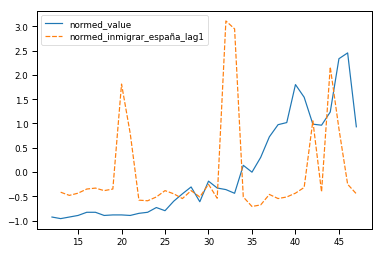

In [378]:
# huh, no pattern. let's look at colombia --> spain

colombia_to_es['normed_value'] = (colombia_to_es['Value'] - np.mean(colombia_to_es['Value']))/np.std(colombia_to_es['Value'])                                                                                            
colombia_to_es['normed_inmigrar_españa_lag1'] = (colombia_to_es['inmigrar_españa_lag1'] - np.mean(colombia_to_es['inmigrar_españa_lag1']))/np.std(colombia_to_es['inmigrar_españa_lag1'])

sns.lineplot(data=colombia_to_es[['normed_value','normed_inmigrar_españa_lag1']])


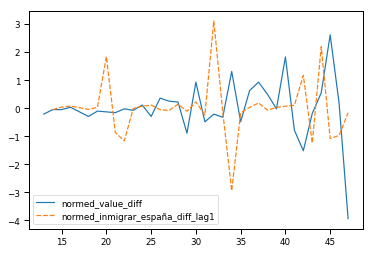

In [379]:
# last shot -- what about differences?

colombia_to_es['normed_value_diff'] = (colombia_to_es['Value_diff'] - np.mean(colombia_to_es['Value_diff']))/np.std(colombia_to_es['Value_diff'])                                                                                            
colombia_to_es['normed_inmigrar_españa_diff_lag1'] = (colombia_to_es['inmigrar_españa_diff_lag1'] - np.mean(colombia_to_es['inmigrar_españa_diff_lag1']))/np.std(colombia_to_es['inmigrar_españa_diff_lag1'])

sns.lineplot(data=colombia_to_es[['normed_value_diff','normed_inmigrar_españa_diff_lag1']])


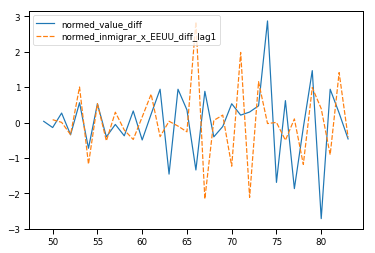

In [383]:
# okay, but what about immigration and EEUU interaction

colombia_to_us['normed_value_diff'] = (colombia_to_us['Value_diff'] - np.mean(colombia_to_us['Value_diff']))/np.std(colombia_to_us['Value_diff'])                                                                                            
colombia_to_us['normed_inmigrar_x_EEUU_diff_lag1'] = (colombia_to_us['inmigrar_x_EEUU_diff_lag1'] - np.mean(colombia_to_us['inmigrar_x_EEUU_diff_lag1']))/np.std(colombia_to_us['inmigrar_x_EEUU_diff_lag1'])

sns.lineplot(data=colombia_to_us[['normed_value_diff','normed_inmigrar_x_EEUU_diff_lag1']])


In [574]:
train_X = refugees_wlags.ix[refugees_wlags['Name_origin'] != "Venezuela", refugees_wlags.columns != "Value"].fillna(0)
train_Y = refugees_wlags.ix[refugees_wlags['Name_origin'] != "Venezuela","Value"].fillna(0)

test_X = refugees_wlags.ix[refugees_wlags['Name_origin'] == "Venezuela", refugees_wlags.columns != "Value"].fillna(0)
test_Y = refugees_wlags.ix[refugees_wlags['Name_origin'] == "Venezuela","Value"].fillna(0)

In [509]:
train_X

,date_recode,Code_origin,Code_destination,Name_origin,Name_destination,llegada,asilo,ciudadania,consulado,aduana,...,indocumentado_x_solicitante_lag1,indocumentado_x_solicitante_lag2,indocumentado_x_solicitante_diff,indocumentado_x_solicitante_diff_lag1,indocumentado_x_indocumentado_lag1,indocumentado_x_indocumentado_lag2,indocumentado_x_indocumentado_diff,indocumentado_x_indocumentado_diff_lag1,origin_factor,destination_factor
0,2017-01-01,CL,US,Chile,United States,33.40,29.20,21.60,46.80,46.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2017-02-01,CL,US,Chile,United States,30.25,31.50,23.75,48.50,32.50,...,0.0000,NaN,73.3125,NaN,0.0000,NaN,162.5625,NaN,0,0
2,2017-03-01,CL,US,Chile,United States,27.50,32.25,55.50,47.00,27.50,...,73.3125,0.0000,166.6875,73.3125,162.5625,0.0000,1437.4375,162.5625,0,0
3,2017-04-01,CL,US,Chile,United States,25.20,45.40,50.00,39.00,28.20,...,240.0000,73.3125,-240.0000,166.6875,1600.0000,162.5625,-1600.0000,1437.4375,0,0
4,2017-05-01,CL,US,Chile,United States,24.50,39.25,58.25,37.75,50.50,...,0.0000,240.0000,0.0000,-240.0000,0.0000,1600.0000,0.0000,-1600.0000,0,0
5,2017-06-01,CL,US,Chile,United States,24.50,31.75,79.25,39.00,34.25,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0
6,2017-07-01,CL,US,Chile,United States,22.40,33.80,38.00,44.80,31.40,...,0.0000,0.0000,407.6800,0.0000,0.0000,0.0000,384.1600,0.0000,0,0
7,2017-08-01,CL,US,Chile,United States,20.75,26.75,46.75,41.50,25.50,...,407.6800,0.0000,-407.6800,407.6800,384.1600,0.0000,-384.1600,384.1600,0,0
8,2017-09-01,CL,US,Chile,United States,25.50,43.75,45.50,44.50,31.00,...,0.0000,407.6800,0.0000,-407.6800,0.0000,384.1600,0.0000,-384.1600,0,0
9,2017-10-01,CL,US,Chile,United States,24.60,38.00,46.80,40.40,29.80,...,0.0000,0.0000,37.8400,0.0000,0.0000,0.0000,73.9600,0.0000,0,0


In [516]:
# using select-k-best

kbest_select = SelectKBest(mutual_info_regression, k=10)
kbest_fit = kbest_select.fit(train_X.iloc[:,5:], train_Y)

In [559]:
cols = kbest_select.get_support(indices=True)
selected_columns = train_X.ix[:,cols]
selected_columns_names = selected_columns.columns

In [560]:
selected_columns_names

Index(['españa', 'solicitante', 'indocumentado', 'asilo_x_naturalizacion',
       'traficante_x_EEUU', 'visa_x_EEUU', 'asilo_x_traficante_lag1',
       'migrante_x_llegada_lag1', 'turista_x_llegada_lag1',
       'indocumentado_x_solicitante_diff_lag1'],
      dtype='object')

In [587]:
# yet another regression
ols_4 = smf.ols('Value ~ españa + solicitante + indocumentado + asilo_x_naturalizacion + traficante_x_EEUU + visa_x_EEUU + asilo_x_traficante_lag1 + migrante_x_llegada_lag1 + turista_x_llegada_lag1 + indocumentado_x_solicitante_diff_lag1 + C(Code_origin)',data=refugees_wlags)
ols_4_fit = ols_4.fit()
ols_4_fit.summary()

PatsyError: Error interpreting categorical data: all items must be hashable
    Value ~ españa + solicitante + indocumentado + asilo_x_naturalizacion + traficante_x_EEUU + visa_x_EEUU + asilo_x_traficante_lag1 + migrante_x_llegada_lag1 + turista_x_llegada_lag1 + indocumentado_x_solicitante_diff_lag1 + C(Code_origin)
                                                                                                                                                                                                                                   ^^^^^^^^^^^^^^

Text(0.5, 1.0, 'ugh')

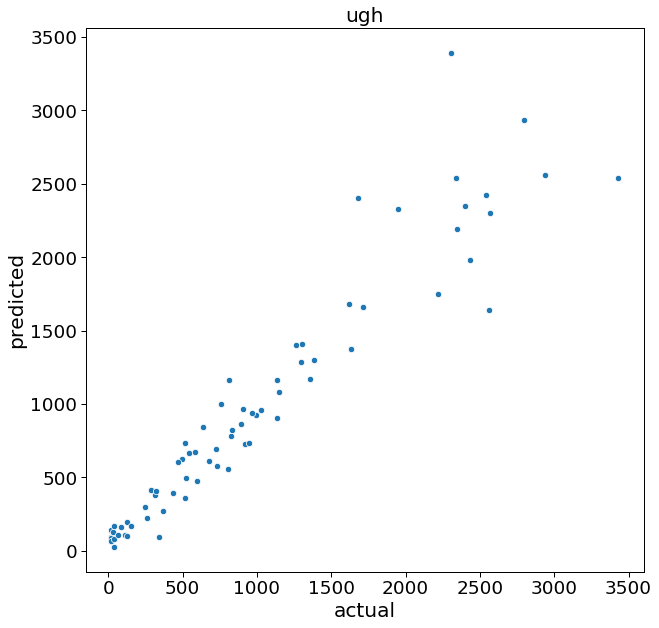

In [576]:
# above model fit
plt.figure(figsize=(10,10))
p1 = prediction_vs_result(ols_4_fit,test_Y,test_X)
sns.set_context("paper",font_scale=2.1)
sns.scatterplot(x='actual', y='predicted', data=p1, s=40).set_title("ugh")

In [581]:
# gaussian process

gp = GaussianProcessRegressor() # default parameters
gp_fit = gp.fit(selected_columns, train_Y)
predicted = gp.predict(test_X.ix[:,cols])

In [582]:
predicted

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])